In [148]:
import math

class Value:
    def __init__(self,data,_children=(),_op='',label =''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda:None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self,other): 
        if not isinstance(other,Value): other = Value(other)
        out = Value(self.data+other.data,(self,other),"+")
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __radd__(self,other):
        return self.__add__(other)
    
    def __neg__(self):
        return self*(-1)
    
    # def __sub__(self,other):
    #     if not isinstance(other,Value): other = Value(other)
    #     out = Value(self.data-other.data,(self,other),"-")
    #     def _backward():
    #         self.grad += out.grad
    #         other.grad -= out.grad
    #     out._backward = _backward
    #     return out

    def __sub__(self,other):
        return self.__add__(other.__neg__())
    
    def __rsub__(self,other):
        return self.__sub__(other)
    
    def __truediv__(self,other):
        return self.data * other.data ** -1
    
    def __mul__(self,other):
        if not isinstance(other,Value): other = Value(other)
        out = Value(self.data*other.data,(self,other),"*")
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self,other):
        return self.__mul__(other)
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only support int or float" 
        out = Value(self.data**other,(self,),f"**{other}")
        def _backward():
            self.grad += other*self.data**(other-1)*out.grad
        self._backward = _backward
        return out 
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)  / (math.exp(2*x) + 1)
        out = Value(t,(self,),label="tanh")
        def _backward():
            self.grad += (1 - t**2)*out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),label="exp")
        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        return out
    
    
    

In [149]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10,label='c')
e = a*b ; e.label = 'e'
d = e+c ; d.label = 'd'
f = Value(-2, label = 'f')
L = d *f  ; L.label = 'L'
L._prev
# c._op

{Value(data=-2), Value(data=4.0)}

In [150]:
import graphviz

In [151]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

In [152]:
def draw_dot(root):
    g = graphviz.Digraph('gradient',format="svg",graph_attr={'rankdir':'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid =str(id(n))
        g.node(name=uid,label="%s | data %.4f | grad %.4f" % (n.label,n.data,n.grad),shape='record')
        if n._op:
            g.node(name=uid+n._op,label=n._op)
            g.edge(uid+n._op,uid)
    
    for n1 , n2 in edges:
        g.edge(str(id(n1)),str(id(n2)) + n2._op)
    
    return g

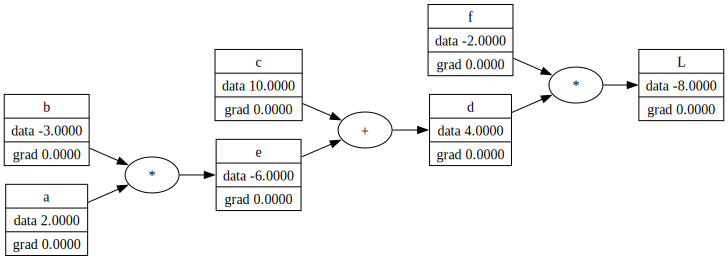

In [153]:
draw_dot(L)

## Derivative Formula
The derivative formula is given by:

$$\frac{f(x+h) - f(x)}{h}$$

### Derivative of $L$ with respect to $L$
$$\frac{dL}{dL} = 1$$

### Derivative of $L$ with respect to $d$
$$L = d \cdot f$$
$$\frac{dL}{dd} = \frac{(d+h) \cdot f - (d \cdot f)}{h}$$
$$\quad\quad\quad\quad= \frac{h \cdot f}{h}$$
$$\quad\quad\quad\quad= f$$

### Derivative of $L$ with respect to $f$
$$\frac{dL}{df} = d$$

### Derivative of $L$ with respect to $e$
$$L = f \cdot (e + c)$$
$$\frac{dL}{de} = \frac{dL}{dd} \cdot \frac{dd}{de}$$
$$\quad\quad\quad= f$$

### Derivative of $L$ with respect to $c$
$$\frac{dL}{dc} = \frac{dL}{dd} \cdot \frac{dd}{dc}$$
$$\quad\quad\quad= f$$

### Derivative of $L$ with respect to $a$
$$L = f \cdot (c + (a \cdot b))$$
$$\frac{dL}{da} = \frac{dL}{dd} \cdot \frac{dd}{de} \cdot b$$
$$\quad\quad\quad= f \cdot b$$

### Derivative of $L$ with respect to $b$
$$\frac{dL}{db} = f \cdot a$$


### Raw format
Derivative forumula 
f(x+h) - f(x) / h 


### derivative of L with respect to L 
dL / dL = 1 

### derivative of L with respect to d 
L = d * f 
dL / dd = (d+h)*f - (d*f) / h 
        = h*f / h 
        = f 

### derivative of L with respect to f 
dL / df = d 

### derivative of L with respect to e 
L = f * (e + c)
dL/ de = (dL / dd) * (dd / de) 
d = e + c
dd / de = 1 
==> dL / de = f

### derivative of L with respect to c 
dL / dc = (dL / dd ) * (dd / dc)
dd / dc = 1 
==> dL / dc = f 

### derivative of L with respect to a 
L = f * (c + (a*b))
dL / da = (dL / dd) * (dd / da)
        = (dL / dd) * (dd / de) * (de / da)
        = (dL / dd) * (dd / de) * b
        = f * 1 * b
        = f * b 

### derivative of L with to b 
dL / fb = f * a



In [154]:
L.grad = 1
h = 0.0001

In [155]:


def test(): 
    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    c = Value(10,label='d')
    e = a*b ; e.label = 'e'
    d = e+c ; d.label = 'd'
    f = Value(-2, label = 'f')
    L = d *f   ; L.label = 'L'

    a = Value(2.0,label='a')
    # derivative with respect to b with add a little number which is h
    b = Value(-3.0+h,label='b')
    c = Value(10,label='d')
    e = a*b ; e.label = 'e'
    d = e+c ; d.label = 'd'
    f = Value(-2, label = 'f')
    L2 = d *f  ; L.label = 'L'
    #L2.data += h


    print((L2.data - L.data)/h)

test()



-4.000000000008441


In [156]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
b = Value(6.88137358,label='b')
x1w1 = x1*w1 ; x1w1.label = 'x1w1' 
x2w2 = x2*w2 ; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2 ; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh() ; o.label = 'o'



In [157]:
o.grad = 1.0
## do/dn = do/do * do/dn = o.grad * (1.0 - o.data**2)
n.grad = (1.0 - o.data**2) * o.grad
x1w1x2w2.grad = 1.0 * n.grad
## do/db = do/dn * dn/db = n.grad * 1
b.grad = 1.0 * n.grad
## do/dx1w1 = do/dn * dn/dx1w1 = n.grad * 1
x1w1.grad = 1.0 * n.grad
x2w2.grad = 1.0 * n.grad

## do/dw1 = do/dx1w1 * dx1w1/dw1 = dx1w1 * x1.data
w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data

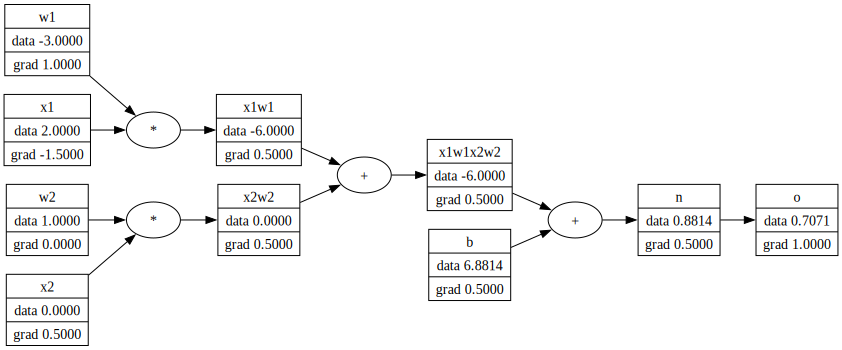

In [158]:
draw_dot(o)

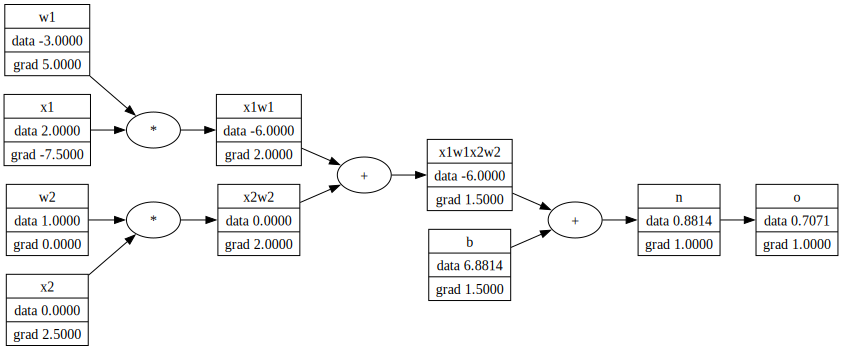

In [159]:
o.grad = 1.0
o.backward()
draw_dot(o)

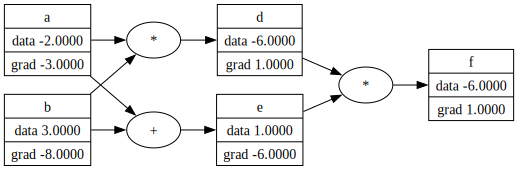

In [160]:
a = Value(-2.0,label='a')
b = Value(3.0,label='b')
d = a*b ; d.label = 'd'
e = a+b ; e.label = 'e'
f = d * e ; f.label = 'f'
f.backward()

draw_dot(f)

In [162]:
a - 2

Value(data=-4.0)

In [144]:
2 + a

Value(data=0.0)

In [164]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
b = Value(6.88137358,label='b')
x1w1 = x1*w1 ; x1w1.label = 'x1w1' 
x2w2 = x2*w2 ; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2 ; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh() ; o.label = 'o'
o.backward()


In [166]:
print(o.data)
print(w1.grad)
print(w2.grad)
print(x1.grad)  
print(x2.grad)

0.707106777676776
1.000000009927133
0.0
-1.5000000148906993
0.5000000049635664


In [ ]:
## doing the same thing but using pytorch

import torch

x1 = torch.tensor([2.0],requires_grad=True)
x2 = torch.tensor([0.0],requires_grad=True)
w1 = torch.tensor([-3.0],requires_grad=True)
w2 = torch.tensor([1.0],requires_grad=True)

b = torch.tensor([6.88137358],requires_grad=True)

n = x1*w1 + x2*w2 + b 
o = torch.tanh(n)
o.backward()

In [ ]:
print(o.data.item())
print(w1.grad.item())
print(w2.grad.item())
print(x1.grad.item())  
print(x2.grad.item())

